# XGBoost Algorithm with MFCC Feature Extraction

# Mount to G Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Import

In [ ]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sn
import xgboost as xgb

import scipy

import librosa
import librosa.display

from matplotlib import pyplot as plt
from scipy.stats import linregress
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Parameters

In [ ]:
window_size = 85
work_dir = 'drive/My Drive/Datasets/deep_breath_mmwave/' # gdrive folder
train_set = 'csv/train_dataset_window_size_'+str(window_size)+'_min_frame_length_85.csv' # train set relative to work_dir 
test_set = 'csv/test_dataset_window_size_'+str(window_size)+'_min_frame_length_85.csv' # test set relative to work_dir 

In [ ]:
class_to_index = {
    'hold' : 0,
    'normal' :1,
    'deep' : 2,
    'quick': 3,
    'deep_quick': 4
}

# Load Dataset


In [ ]:
train_df = pd.read_csv(work_dir+train_set)
test_df = pd.read_csv(work_dir+test_set)

# Data Analysis and Preparation

In [ ]:
print('train:',train_df.shape)
print(train_df['labels'].value_counts())
print()
print('test:',test_df.shape)
print(test_df['labels'].value_counts())

train: (3200, 87)
deep          640
quick         640
hold          640
deep_quick    640
normal        640
Name: labels, dtype: int64

test: (800, 87)
hold          160
deep_quick    160
deep          160
quick         160
normal        160
Name: labels, dtype: int64


# MFCC Feature Extraction

In [ ]:
def extract_mfcc(df_, sr=60, n_mfcc=13):
  df_mfcc = []
  with tqdm(total=df_.shape[0]) as pbar: 
      for i,row in df_.iterrows():
        pbar.update(1)
        y = np.array(row[:-2]).astype(np.float32)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = np.squeeze(mfccs, axis=1)
        df_mfcc.append([*mfccs, row[-2]])
      df_mfcc = pd.DataFrame(df_mfcc, columns=[*np.arange(0,13),'labels'])
  return df_mfcc


In [ ]:
train_df_mfcc = extract_mfcc(train_df)

  0%|          | 0/3200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=85
  n_fft, y.shape[-1]
100%|██████████| 3200/3200 [00:19<00:00, 163.06it/s]


In [ ]:
train_df_mfcc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,labels
0,51.400898,184.093811,84.732697,33.559311,18.096462,15.069372,28.991951,10.938621,0.575912,3.981109,3.622868,-2.474621,-9.265508,deep
1,90.621468,137.907043,65.562416,42.800358,33.523911,32.409008,14.788023,15.936674,7.711355,8.106028,2.608246,2.464756,-4.315663,deep
2,128.784927,132.943634,67.249130,38.763115,20.312099,12.503655,16.321896,10.315442,12.639545,11.909327,6.927862,3.321593,4.094015,deep
3,59.191261,153.139084,85.338280,49.753796,25.523876,19.084799,8.279139,14.987810,9.275911,1.858274,-1.167313,-4.925354,-12.718996,deep
4,67.595009,146.096680,69.831131,38.885857,29.088377,30.840919,21.068012,21.941530,8.844509,-0.551090,-5.266858,-2.160193,0.022506,deep


# Data Standarization

In [ ]:
train_x = train_df_mfcc.drop('labels', axis=1).values
test_x = train_df_mfcc.drop('labels', axis=1).values

standard_scaler = preprocessing.StandardScaler()
standard_scaler = standard_scaler.fit(train_x) # fit only on training data

# transform both train and test
train_x_scaled = standard_scaler.transform(train_x) 
test_x_scaled = standard_scaler.transform(test_x)

train_df_mfcc.loc[:,train_df_mfcc.columns[:-1]] = train_x_scaled
train_df_mfcc.loc[:,train_df_mfcc.columns[:-1]] = test_x_scaled


In [ ]:
with open(work_dir+'standar_scaler_MFCC_'+train_set[4:-4]+'.pickle', 'wb') as o:
  pickle.dump(standard_scaler, o, protocol=2.0)

In [ ]:
with open(work_dir+'standar_scaler_MFCC_'+train_set[4:-4]+'.pickle', 'rb') as o:
  standard_scaler = pickle.load(o)

In [ ]:
train_df_mfcc.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03,3.200000e+03
mean,-7.837481e-17,-3.604755e-16,-7.008283e-17,4.543935e-16,-2.398082e-16,-2.762374e-16,2.360612e-16,3.683859e-16,2.068484e-16,1.780520e-16,1.453698e-17,-1.636885e-16,-8.190280e-17
std,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00,1.000156e+00
min,-3.365055e+00,-3.453053e+00,-5.602278e+00,-4.600819e+00,-4.401108e+00,-3.494398e+00,-3.826812e+00,-3.861394e+00,-3.635276e+00,-3.887966e+00,-4.040682e+00,-4.228042e+00,-3.711726e+00
25%,-4.116338e-01,-7.415672e-01,-5.139667e-01,-6.506114e-01,-6.990516e-01,-6.641448e-01,-6.622481e-01,-6.429744e-01,-6.668788e-01,-6.315811e-01,-6.393335e-01,-6.280604e-01,-6.309503e-01
50%,2.374610e-01,-1.445520e-01,9.409762e-02,4.666778e-02,6.863097e-02,1.034450e-01,7.638232e-02,1.056661e-01,6.803962e-02,4.679627e-02,2.423606e-03,-5.719533e-02,-5.068832e-02
75%,7.420971e-01,5.876812e-01,6.579223e-01,7.044034e-01,7.339384e-01,7.078194e-01,7.254218e-01,7.078533e-01,6.783809e-01,6.474548e-01,6.425239e-01,5.491309e-01,5.594409e-01
max,1.661478e+00,3.817338e+00,2.861271e+00,3.389151e+00,3.577376e+00,4.025922e+00,3.028608e+00,4.739064e+00,3.104996e+00,3.831077e+00,5.161159e+00,4.818487e+00,5.346622e+00


# PCA & LDA

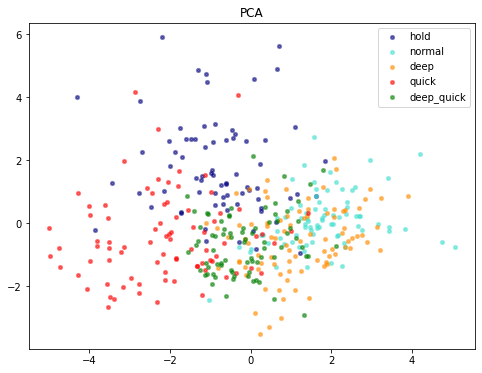

<Figure size 432x288 with 0 Axes>

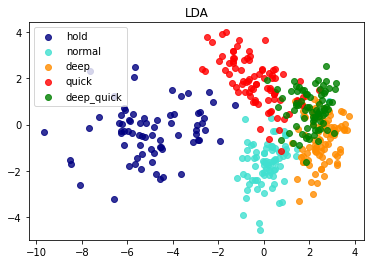

In [ ]:
sample_df = train_df_mfcc.sample(400, random_state=1)
X = sample_df.drop(['labels'], axis=1)
y = sample_df['labels'].map(class_to_index)
target_names = np.array(list(class_to_index.keys()))

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, lw=lw,
                label=target_name, s=10)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.figure()

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')

plt.show()

# Training

In [ ]:
X_train = train_df_mfcc.drop(['labels'], axis=1)
y_train = train_df_mfcc['labels']
X_test = train_df_mfcc.drop(['labels'], axis=1)
y_test = train_df_mfcc['labels']

# A parameter grid for XGBoost
params = {
        'n_estimators': [200, 300, 400],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.1, 0.01, 0.001]
        }

xgb_model = xgb.XGBClassifier(objective="multi:softmax",
                              n_jobs=-1,
                              random_state=42)

In [ ]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, n_jobs=-1, cv=skf.split(X_train.values,y_train.values), verbose=3)

grid_search.fit(X_train.values, y_train.values)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
with open(work_dir+'xgb_model_MFCC_'+train_set[4:-4]+'.pickle', 'wb') as o:
  pickle.dump(best_model, o, protocol=2.0)

In [ ]:
grid_search.best_estimator_


XGBClassifier(n_estimators=200, n_jobs=-1, objective='multi:softprob',
              random_state=42)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [ ]:
window_size

85

# Evaluation

In [ ]:
def evaluate(test_set, best_model, standard_scaler, save_result=False):
  # load dataset
  test_df = pd.read_csv(work_dir+test_set)

  # extract statistical features
  train_df_mfcc = extract_mfcc(test_df)

  # drop unused features
  # test_df_stats = drop_stats_features(test_df_stats)
  # print("features:", test_df_stats.columns)

  # standardize
  test_x = train_df_mfcc.drop('labels', axis=1).values
  test_x_scaled = standard_scaler.transform(test_x)
  train_df_mfcc.loc[:,train_df_mfcc.columns[:-1]] = test_x_scaled

  # separate feature and label
  X_test = train_df_mfcc.drop(['labels'], axis=1)
  y_test = train_df_mfcc['labels']

  # predict
  y_preds = best_model.predict(X_test.values)

  if save_result:
    test_df['predictions'] = y_preds
    test_df.to_csv(work_dir+'prediction_result/'+'prediction_'+test_set[4:], index=False)

  # display confusion matrix
  print('\n------------ Confusion Matrix ------------')
  cm = confusion_matrix(y_test.values, y_preds, labels=list(class_to_index.keys()))
  df_cm = pd.DataFrame(cm, index = list(class_to_index.keys()),
                    columns = list(class_to_index.keys()))
  plt.figure(figsize = (8,8))
  sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
  plt.show()

  # display classification report
  print('\n------------ Classification Report ------------')
  print(classification_report(y_test.values, y_preds, digits=5))

# Window Size 85

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'n_estimators': 200, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42, 'subsample': 1, 'verbosity': 1}


  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=85
  n_fft, y.shape[-1]
100%|██████████| 800/800 [00:04<00:00, 166.07it/s]



------------ Confusion Matrix ------------


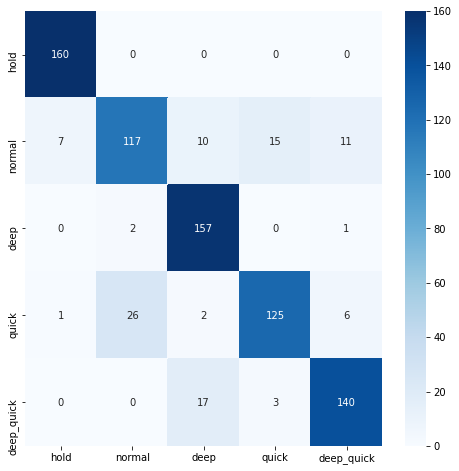


------------ Classification Report ------------
              precision    recall  f1-score   support

        deep    0.84409   0.98125   0.90751       160
  deep_quick    0.88608   0.87500   0.88050       160
        hold    0.95238   1.00000   0.97561       160
      normal    0.80690   0.73125   0.76721       160
       quick    0.87413   0.78125   0.82508       160

    accuracy                        0.87375       800
   macro avg    0.87271   0.87375   0.87118       800
weighted avg    0.87271   0.87375   0.87118       800



In [ ]:
train_set = 'csv/train_dataset_window_size_85_min_frame_length_85.csv'
test_set = 'csv/test_dataset_window_size_85_min_frame_length_85.csv'
with open(work_dir+'xgb_model_MFCC_'+train_set[4:-4]+'.pickle', 'rb') as o:
  best_model = pickle.load(o)
with open(work_dir+'standar_scaler_MFCC_'+train_set[4:-4]+'.pickle', 'rb') as o:
  standard_scaler = pickle.load(o)

print(best_model.get_xgb_params(),flush=True)

evaluate(test_set, best_model, standard_scaler)